# GSD Estimation: Regression Tree CNN (Lee & Sull, 2019)

**Статья:** Lee, J., & Sull, S. (2019). *Regression Tree CNN for Estimation of Ground Sampling Distance Based on Floating-Point Representation.* Remote Sensing, 11(19), 2276.

**Ключевая идея:** GSD = 20 × mantissa × 2^exponent, где:
- exponent ∈ {0,1,2,3,4} — классификация (5 классов)
- mantissa ∈ [0.75, 1.5] — регрессия

| e | Диапазон GSD | Разрешение |
|---|--------------|------------|
| 0 | [15, 30) см | Очень высокое |
| 1 | [30, 60) см | Высокое |
| 2 | [60, 120) см | Среднее |
| 3 | [120, 240) см | Низкое |
| 4 | [240, 480] см | Очень низкое |

In [12]:
from __future__ import annotations

import copy
import json
import os
import random
import warnings
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import timm
from PIL import Image
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Визуализация
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('seaborn-whitegrid')
sns.set_palette('husl')
%matplotlib inline

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# Воспроизводимость и конфигурация
# ═══════════════════════════════════════════════════════════════════════════════

SEED = 42


def seed_everything(seed: int = 42) -> None:
    """Set random seed for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


seed_everything(SEED)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}" + (f" ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else ""))

Device: cuda:0 (NVIDIA GeForce RTX 3090)


In [14]:
# Вычисляем корень проекта относительно ноутбука (ищем pyproject.toml)
def _find_project_root() -> Path:
    """Find project root by looking for pyproject.toml."""
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return cwd.parent if cwd.name == "notebooks" else cwd

_PROJECT_ROOT = _find_project_root()


@dataclass(frozen=True, slots=True)
class Config:
    """Training configuration for GSD estimation (Lee & Sull, 2019)."""
    
    # Пути
    inria_path: str = str(_PROJECT_ROOT / "data" / "raw")
    checkpoint_dir: str = str(_PROJECT_ROOT / "checkpoints")
    
    # Датасет
    patch_size: int = 256
    num_patches_per_image: int = 8
    test_patches_per_image: int = 4
    base_gsd: float = 30.0  # INRIA: 30 см/пиксель
    # Log GSD scale согласно статье: GSD = 15 × 2^x, где x uniform в [0, 5]
    # Это даёт больше samples с малым GSD (высоким разрешением)
    # Генерируем 21 значение равномерно по log scale
    resample_gsds: Tuple[float, ...] = tuple(
        15.0 * (2.0 ** (i / 4)) for i in range(21)  # x = 0, 0.25, 0.5, ..., 5.0
    )  # 15.0, 17.8, 21.2, 25.2, 30.0, ..., 480.0
    
    # Модель
    backbone: str = "resnet101"  # ResNet-101 согласно статье
    num_exponent_classes: int = 5
    
    # Обучение (согласно статье)
    batch_size: int = 32
    epochs: int = 32  # 32 эпохи, decay на 16 и 24
    learning_rate: float = 1e-4
    weight_decay: float = 1e-4  # L2 regularization согласно статье
    lr_decay_epochs: Tuple[int, ...] = (16, 24)  # decay × 0.1 на этих эпохах
    lr_decay_gamma: float = 0.1
    lambda_mantissa: float = 10.0  # λ из статьи
    grad_clip_norm: float = 1.0
    early_stopping_patience: int = 10
    
    # Данные (90% train согласно статье)
    train_val_split: float = 0.9
    num_workers: int = min(4, os.cpu_count() or 1)
    use_amp: bool = True


cfg = Config()
print(f"INRIA path: {cfg.inria_path}")
print(f"Resample GSDs: {cfg.resample_gsds}")

INRIA path: /home/user/code/dls_project/data/raw
Resample GSDs: (15.0, 17.838106725040817, 21.213203435596427, 25.226892457611434, 30.0, 35.67621345008163, 42.42640687119285, 50.45378491522287, 60.0, 71.35242690016327, 84.8528137423857, 100.90756983044574, 120.0, 142.70485380032653, 169.7056274847714, 201.81513966089148, 240.0, 285.40970760065306, 339.4112549695428, 403.63027932178295, 480.0)


In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# Floating-Point представление GSD (Lee & Sull, 2019)
# GSD = 20 × mantissa × 2^exponent
# ═══════════════════════════════════════════════════════════════════════════════

# Валидный диапазон GSD по статье
GSD_MIN, GSD_MAX = 15.0, 480.0


def gsd_to_exponent(gsd: float) -> int:
    """
    Convert GSD (cm/pixel) to exponent class.
    
    Class boundaries: [15×2^e, 30×2^e) for e ∈ {0,1,2,3,4}
    Valid GSD range: [15, 480] cm
    """
    # Клипаем к валидному диапазону с warning
    if gsd < GSD_MIN or gsd > GSD_MAX:
        warnings.warn(f"GSD {gsd} cm outside valid range [{GSD_MIN}, {GSD_MAX}], clipping")
        gsd = np.clip(gsd, GSD_MIN, GSD_MAX)
    
    # Граница класса e: GSD < 30 × 2^e
    e = 0
    while e < 4 and gsd >= 30.0 * (2 ** e):
        e += 1
    return e


def gsd_to_mantissa(gsd: float, exponent: int) -> float:
    """
    Convert GSD to mantissa given exponent.
    
    mantissa = GSD / (20 × 2^exponent), clipped to [0.75, 1.5]
    """
    gsd = np.clip(gsd, GSD_MIN, GSD_MAX)
    mantissa = gsd / (20.0 * (2 ** exponent))
    return float(np.clip(mantissa, 0.75, 1.5))


# Верификация: все классы покрыты
print("GSD → (exponent, mantissa) → reconstructed:")
for gsd in cfg.resample_gsds:
    e = gsd_to_exponent(gsd)
    m = gsd_to_mantissa(gsd, e)
    print(f"  {gsd:>3} cm → e={e}, m={m:.3f} → {20*m*2**e:.1f} cm")

GSD → (exponent, mantissa) → reconstructed:
  15.0 cm → e=0, m=0.750 → 15.0 cm
  17.838106725040817 cm → e=0, m=0.892 → 17.8 cm
  21.213203435596427 cm → e=0, m=1.061 → 21.2 cm
  25.226892457611434 cm → e=0, m=1.261 → 25.2 cm
  30.0 cm → e=1, m=0.750 → 30.0 cm
  35.67621345008163 cm → e=1, m=0.892 → 35.7 cm
  42.42640687119285 cm → e=1, m=1.061 → 42.4 cm
  50.45378491522287 cm → e=1, m=1.261 → 50.5 cm
  60.0 cm → e=2, m=0.750 → 60.0 cm
  71.35242690016327 cm → e=2, m=0.892 → 71.4 cm
  84.8528137423857 cm → e=2, m=1.061 → 84.9 cm
  100.90756983044574 cm → e=2, m=1.261 → 100.9 cm
  120.0 cm → e=3, m=0.750 → 120.0 cm
  142.70485380032653 cm → e=3, m=0.892 → 142.7 cm
  169.7056274847714 cm → e=3, m=1.061 → 169.7 cm
  201.81513966089148 cm → e=3, m=1.261 → 201.8 cm
  240.0 cm → e=4, m=0.750 → 240.0 cm
  285.40970760065306 cm → e=4, m=0.892 → 285.4 cm
  339.4112549695428 cm → e=4, m=1.061 → 339.4 cm
  403.63027932178295 cm → e=4, m=1.261 → 403.6 cm
  480.0 cm → e=4, m=1.500 → 480.0 cm


In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# Датасет INRIA
# ═══════════════════════════════════════════════════════════════════════════════

inria_train_images = Path(cfg.inria_path) / "train" / "images"
inria_test_images = Path(cfg.inria_path) / "test" / "images"

dataset_exists = inria_train_images.exists() and any(inria_train_images.glob("*.tif"))

if dataset_exists:
    train_images = sorted(inria_train_images.glob("*.tif"))
    test_images = sorted(inria_test_images.glob("*.tif")) if inria_test_images.exists() else []
    print(f"Train images: {len(train_images)}, Test images: {len(test_images)}")
else:
    train_images, test_images = [], []
    print(f"Dataset not found at {cfg.inria_path}")
    print("Download from: https://project.inria.fr/aerialimagelabeling/")

Train images: 180, Test images: 180


In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# GSD Dataset с multi-scale training и симуляцией ошибок классификации
# ═══════════════════════════════════════════════════════════════════════════════

# ImageNet нормализация
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def compute_adjusted_mantissa(gsd: float, wrong_exponent: int) -> float:
    """
    Вычисляет adjusted mantissa для симулированной ошибки классификации.
    
    Согласно статье: при ошибке классификации на ±1, модель должна научиться
    выдавать adjusted mantissa, которая компенсирует ошибку экспоненты.
    
    GSD = 20 × m × 2^e → m = GSD / (20 × 2^e)
    """
    m = gsd / (20.0 * (2 ** wrong_exponent))
    return float(np.clip(m, 0.75, 1.5))


class GSDDataset(Dataset):
    """
    Dataset for GSD estimation with multi-scale augmentation (Lee & Sull, 2019).
    
    Multi-scale resampling создаёт патчи с effective GSD = target_gsd.
    
    Simulated classification errors (согласно статье):
        - 10% данных augmented с симулированными ошибками ±1 класс
        - Для этих samples вычисляется adjusted mantissa
        - Это позволяет модели "исправлять" ошибки классификации
    """
    
    def __init__(
        self,
        images_dir: str,
        gsd_cm: float = 30.0,
        patch_size: int = 256,
        num_patches_per_image: int = 4,
        augment: bool = True,
        simulate_class_errors: bool = False,
        class_error_rate: float = 0.1,
        num_classes: int = 5,
        resample_gsds: Optional[List[float]] = None,
        image_files: Optional[List[Path]] = None,
        seed: int = 42
    ):
        self.gsd_cm = gsd_cm
        self.patch_size = patch_size
        self.num_patches_per_image = num_patches_per_image
        self.seed = seed
        self.augment = augment
        self.simulate_class_errors = simulate_class_errors
        self.class_error_rate = class_error_rate
        self.num_classes = num_classes
        self._epoch = 0
        
        images_dir = Path(images_dir)
        self.image_files = list(image_files) if image_files else sorted(
            list(images_dir.glob("*.tif")) + list(images_dir.glob("*.png"))
        )
        if not self.image_files:
            raise FileNotFoundError(f"No images found in {images_dir}")
        
        self.resample_gsds = resample_gsds or [self.gsd_cm]
        self.data = [
            {'path': img, 'original_gsd': self.gsd_cm, 'target_gsd': tgt}
            for img in self.image_files for tgt in self.resample_gsds
        ]
        
        rotation_fill = tuple(int(m * 255) for m in IMAGENET_MEAN)
        if augment:
            self.transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
                transforms.RandomRotation(360, fill=rotation_fill),  # 0~360° согласно статье
                transforms.RandomHorizontalFlip(),  # flip согласно статье
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
    
    def set_epoch(self, epoch: int) -> None:
        """Set epoch for randomization between epochs."""
        self._epoch = epoch
    
    def __len__(self) -> int:
        return len(self.data) * self.num_patches_per_image
    
    def _safe_randint(self, rng: random.Random, low: int, high: int) -> int:
        return low if high <= low else rng.randint(low, high)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        data_item = self.data[idx // self.num_patches_per_image]
        original_gsd = data_item['original_gsd']
        target_gsd = data_item['target_gsd']
        
        with Image.open(data_item['path']) as img:
            img_array = np.array(img.convert('RGB'))
        h, w = img_array.shape[:2]
        
        if h < self.patch_size or w < self.patch_size:
            scale = max(self.patch_size / h, self.patch_size / w)
            new_h, new_w = int(h * scale) + 1, int(w * scale) + 1
            img_array = cv2.resize(img_array, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            h, w = img_array.shape[:2]
        
        epoch_offset = self._epoch * len(self) if self.augment else 0
        rng = random.Random(self.seed + idx + epoch_offset)
        
        # Multi-scale ресэмплирование
        if target_gsd < original_gsd:
            source_size = int(self.patch_size * target_gsd / original_gsd)
            source_size = max(32, min(source_size, min(h, w)))
            y = self._safe_randint(rng, 0, h - source_size)
            x = self._safe_randint(rng, 0, w - source_size)
            patch = img_array[y:y+source_size, x:x+source_size]
            patch = cv2.resize(patch, (self.patch_size, self.patch_size), interpolation=cv2.INTER_LINEAR)
        elif target_gsd > original_gsd:
            source_size = int(self.patch_size * original_gsd / target_gsd)
            source_size = max(32, source_size)
            y = self._safe_randint(rng, 0, h - self.patch_size)
            x = self._safe_randint(rng, 0, w - self.patch_size)
            patch = img_array[y:y+self.patch_size, x:x+self.patch_size]
            patch = cv2.resize(patch, (source_size, source_size), interpolation=cv2.INTER_AREA)
            patch = cv2.resize(patch, (self.patch_size, self.patch_size), interpolation=cv2.INTER_LINEAR)
        else:
            y = self._safe_randint(rng, 0, h - self.patch_size)
            x = self._safe_randint(rng, 0, w - self.patch_size)
            patch = img_array[y:y+self.patch_size, x:x+self.patch_size]
        
        # Истинные exponent и mantissa
        true_exponent = gsd_to_exponent(target_gsd)
        true_mantissa = gsd_to_mantissa(target_gsd, true_exponent)
        
        # Симуляция ошибок классификации (10% данных согласно статье)
        exponent = true_exponent
        mantissa = true_mantissa
        
        if self.simulate_class_errors and self.augment and rng.random() < self.class_error_rate:
            # Симулируем ошибку ±1 класс
            if true_exponent == 0:
                wrong_exponent = 1
            elif true_exponent == self.num_classes - 1:
                wrong_exponent = true_exponent - 1
            else:
                wrong_exponent = true_exponent + rng.choice([-1, 1])
            
            # Adjusted mantissa для компенсации ошибки
            exponent = wrong_exponent
            mantissa = compute_adjusted_mantissa(target_gsd, wrong_exponent)
        
        return {
            'image': self.transform(Image.fromarray(patch)),
            'gsd': torch.tensor(target_gsd, dtype=torch.float32),
            'exponent': torch.tensor(exponent, dtype=torch.long),
            'mantissa': torch.tensor(mantissa, dtype=torch.float32)
        }


print("GSDDataset defined.")

GSDDataset defined.


In [8]:
# Создание датасетов и DataLoader'ов
if dataset_exists:
    # Разделяем изображения (не индексы!) для избежания data leakage
    shuffled_images = list(train_images)
    random.Random(SEED).shuffle(shuffled_images)
    split_idx = int(len(shuffled_images) * cfg.train_val_split)
    train_image_files = shuffled_images[:split_idx]
    val_image_files = shuffled_images[split_idx:]
    
    train_dataset = GSDDataset(
        images_dir=str(inria_train_images),
        gsd_cm=cfg.base_gsd,  # 30 см
        patch_size=cfg.patch_size,
        num_patches_per_image=cfg.num_patches_per_image,
        augment=True,
        simulate_class_errors=True,  # 10% симулированных ошибок согласно статье
        class_error_rate=0.1,
        num_classes=cfg.num_exponent_classes,
        resample_gsds=list(cfg.resample_gsds),
        image_files=train_image_files,
        seed=SEED
    )
    
    val_dataset = GSDDataset(
        images_dir=str(inria_train_images),
        gsd_cm=cfg.base_gsd,  # 30 см
        patch_size=cfg.patch_size,
        num_patches_per_image=cfg.num_patches_per_image,
        augment=False,
        simulate_class_errors=False,  # Без симуляции для валидации
        num_classes=cfg.num_exponent_classes,
        resample_gsds=list(cfg.resample_gsds),
        image_files=val_image_files,
        seed=SEED
    )
    
    # Worker init для воспроизводимости
    def worker_init_fn(worker_id: int) -> None:
        np.random.seed(SEED + worker_id)
        random.seed(SEED + worker_id)
    
    # Generator для воспроизводимости shuffle (только для train)
    train_generator = torch.Generator().manual_seed(SEED)
    
    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, shuffle=True,
        num_workers=cfg.num_workers, pin_memory=True, drop_last=True,
        worker_init_fn=worker_init_fn, generator=train_generator
    )
    val_loader = DataLoader(
        val_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True,
        worker_init_fn=worker_init_fn
    )
    
    print(f"Train: {len(train_dataset)} samples ({len(train_loader)} batches)")
    print(f"Val: {len(val_dataset)} samples ({len(val_loader)} batches)")
else:
    train_loader = val_loader = None
    print("DataLoaders not created — dataset not available.")

Train: 27216 samples (850 batches)
Val: 3024 samples (95 batches)


In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# Binomial Tree Layer (Lee & Sull, 2019) — полная реализация по статье
# - Иерархическая структура с локальной классификацией на каждом уровне
# - Mantissa head через pointwise conv (64→1) до GAP
# - Разная backpropagation: Le для всех уровней, Lm только для выбранного пути
# ═══════════════════════════════════════════════════════════════════════════════




def compute_local_class(gsd: torch.Tensor, level: int, gsd_min: float = 15.0, gsd_ratio: float = 32.0) -> torch.Tensor:
    """
    Вычисляет локальный класс для уровня l на основе GSD.
    Границы: gsd_min × gsd_ratio^(i/(l+1)), i = 0, 1, ..., l+1
    
    Args:
        gsd: [B] GSD values
        level: уровень дерева (l >= 1)
        gsd_min: минимальный GSD (15.0)
        gsd_ratio: gsd_max/gsd_min (32.0 для 15-480)
    
    Returns:
        local_class: [B] индексы классов для уровня l (0 to l)
    """
    # На уровне level имеем level+1 узлов/классов
    num_classes = level + 1
    # Вычисляем log position: x = log(gsd/gsd_min) / log(gsd_ratio) ∈ [0, 1]
    log_pos = torch.log(gsd / gsd_min) / np.log(gsd_ratio)
    log_pos = torch.clamp(log_pos, 0.0, 1.0 - 1e-6)
    # Класс = floor(log_pos × num_classes)
    local_class = (log_pos * num_classes).long()
    return torch.clamp(local_class, 0, num_classes - 1)


class BinomialTreeLayer(nn.Module):
    """
    Binomial Tree Layer для GSD estimation (Lee & Sull, 2019) — полная реализация.
    
    Архитектура точно по статье:
        - Level 0: 1 узел (root) с feature map из CNN
        - Level l: (l+1) узлов с локальной классификацией среди l классов
        - Границы уровня l: gsd_min × (gsd_max/gsd_min)^(i/l), i = 0..l
        - Выбор узла по L2 норме (Equation 11)
        - Mantissa head: два pointwise conv (64→1) на feature map до GAP
        - Backprop: Le для всех уровней, Lm только для выбранного leaf
    
    Параметры из статьи:
        - C = 5 (число классов/leaf nodes)
        - V = 16 (размерность вектора в каждом узле)
    """
    
    def __init__(
        self,
        in_channels: int,
        num_classes: int = 5,
        vector_dim: int = 16,
        gsd_min: float = 15.0,
        gsd_max: float = 480.0
    ):
        super().__init__()
        self.num_classes = num_classes
        self.vector_dim = vector_dim
        self.depth = num_classes  # depth = C для C leaf nodes
        self.gsd_min = gsd_min
        self.gsd_max = gsd_max
        self.gsd_ratio = gsd_max / gsd_min  # 32 для 15-480
        
        # Root convolution: feature map → V-dim vector (level 0, 1 узел)
        self.root_conv = nn.Conv2d(in_channels, vector_dim, kernel_size=1, bias=True)
        
        # Pointwise convolutions для каждого узла на каждом уровне (кроме root)
        # Level l (l >= 1) имеет (l+1) узлов
        self.level_convs = nn.ModuleList()
        for level in range(1, self.depth):
            num_nodes = level + 1
            level_conv = nn.ModuleList([
                nn.Conv2d(vector_dim, vector_dim, kernel_size=1, bias=True)
                for _ in range(num_nodes)
            ])
            self.level_convs.append(level_conv)
        
        # Mantissa regression head: два pointwise conv (согласно статье)
        # Применяется к нормализованному feature map до GAP
        self.mantissa_conv1 = nn.Conv2d(vector_dim, 64, kernel_size=1, bias=True)
        self.mantissa_conv2 = nn.Conv2d(64, 1, kernel_size=1, bias=True)
        
        # He initialization
        self._init_weights()
    
    def _init_weights(self):
        """He initialization согласно статье."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, features: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward pass через полное binomial tree.
        
        Args:
            features: [B, C, H, W] feature map из backbone (без global avg pool)
        
        Returns:
            dict с ключами:
                - class_logits: [B, num_classes] — L2 нормы leaf vectors
                - mantissa: [B] — предсказанная мантисса [0.75, 1.5]
                - selected_class: [B] — выбранный класс (argmax по L2 норме)
                - level_logits: List[Tensor] — L2 нормы для каждого уровня (для локальной классификации)
        """
        B, _, H, W = features.shape
        
        # Level 0: root node
        root_feat = self.root_conv(features)  # [B, V, H, W]
        current_level_feats = [root_feat]  # List of [B, V, H, W]
        
        # Собираем L2 нормы для локальной классификации на каждом уровне
        level_logits = []  # List of [B, num_nodes] для каждого уровня
        
        # Level 0 имеет 1 узел — нет классификации
        # Проходим по уровням дерева (levels 1 to depth-1)
        for level_idx, level_conv in enumerate(self.level_convs):
            level = level_idx + 1  # actual level number (1, 2, ..., depth-1)
            num_nodes = level + 1
            next_level_feats = []
            
            for node_idx in range(num_nodes):
                # Родительские узлы для данного узла
                parent_left = max(0, node_idx - 1)
                parent_right = min(node_idx, level - 1)
                
                if parent_left == parent_right:
                    parent_feat = current_level_feats[parent_left]
                else:
                    # Выбор по L2 норме (Equation 11)
                    left_feat = current_level_feats[parent_left]
                    right_feat = current_level_feats[parent_right]
                    
                    left_norm = left_feat.mean(dim=(2, 3)).norm(p=2, dim=1)
                    right_norm = right_feat.mean(dim=(2, 3)).norm(p=2, dim=1)
                    
                    select_right = (right_norm > left_norm).float().view(B, 1, 1, 1)
                    parent_feat = left_feat * (1 - select_right) + right_feat * select_right
                
                node_feat = level_conv[node_idx](parent_feat)
                next_level_feats.append(node_feat)
            
            # L2 нормы для локальной классификации на этом уровне
            level_norms = []
            for feat in next_level_feats:
                pooled = feat.mean(dim=(2, 3))  # [B, V]
                norm = torch.norm(pooled, p=2, dim=1)  # [B]
                level_norms.append(norm)
            level_logits.append(torch.stack(level_norms, dim=1))  # [B, num_nodes]
            
            current_level_feats = next_level_feats
        
        # Leaf nodes — последний уровень (depth-1)
        # current_level_feats содержит num_classes feature maps [B, V, H, W]
        
        # L2 нормы leaf vectors для финальной классификации
        leaf_vectors_pooled = [feat.mean(dim=(2, 3)) for feat in current_level_feats]
        leaf_stack = torch.stack(leaf_vectors_pooled, dim=1)  # [B, num_classes, V]
        class_logits = torch.norm(leaf_stack, p=2, dim=2)  # [B, num_classes]
        
        # Выбираем класс с максимальной L2 нормой
        selected_class = torch.argmax(class_logits, dim=1)  # [B]
        
        # Выбираем feature map выбранного leaf для mantissa regression
        # Нужно собрать [B, V, H, W] из списка feature maps по selected_class
        leaf_feats_stack = torch.stack(current_level_feats, dim=1)  # [B, C, V, H, W]
        batch_indices = torch.arange(B, device=features.device)
        selected_feat = leaf_feats_stack[batch_indices, selected_class]  # [B, V, H, W]
        
        # Нормализуем feature map по L2 норме (поэлементно по V измерению)
        feat_norm = torch.norm(selected_feat, p=2, dim=1, keepdim=True) + 1e-8  # [B, 1, H, W]
        normalized_feat = selected_feat / feat_norm  # [B, V, H, W]
        
        # Mantissa regression через два pointwise conv, затем GAP
        m1 = torch.relu(self.mantissa_conv1(normalized_feat))  # [B, 64, H, W]
        m2 = self.mantissa_conv2(m1)  # [B, 1, H, W]
        mantissa_raw = m2.mean(dim=(2, 3)).squeeze(-1)  # [B]
        mantissa = torch.sigmoid(mantissa_raw) * 0.75 + 0.75  # [0.75, 1.5]
        
        return {
            'class_logits': class_logits,
            'mantissa': mantissa,
            'selected_class': selected_class,
            'level_logits': level_logits  # для локальной классификации на промежуточных уровнях
        }


class RegressionTreeCNN(nn.Module):
    """
    Regression Tree CNN for GSD estimation (Lee & Sull, 2019) — полная реализация.
    
    Architecture:
        - Backbone: ResNet-101 (frozen, pretrained on ImageNet)
        - Binomial Tree Layer: полная иерархическая структура с локальной классификацией
        - Mantissa head: pointwise conv (64→1) до GAP
        - Output: GSD = 20 × mantissa × 2^exponent (cm/pixel)
    
    Backpropagation согласно статье:
        - Le (classification loss) применяется ко всем уровням дерева
        - Lm (mantissa loss) применяется только к выбранному пути
    """
    
    def __init__(
        self,
        backbone: str = 'resnet101',
        num_exponent_classes: int = 5,
        vector_dim: int = 16,
        gsd_min: float = 15.0,
        gsd_max: float = 480.0
    ):
        super().__init__()
        self.num_classes = num_exponent_classes
        self.gsd_min = gsd_min
        self.gsd_max = gsd_max
        self.gsd_ratio = gsd_max / gsd_min
        
        # Backbone без avgpool и fc (согласно статье)
        # Используем timm — загружает веса с huggingface (альтернатива pytorch.org)
        resnet = timm.create_model(backbone, pretrained=True, features_only=True, out_indices=[-1])
        print(f"Loaded {backbone} with pretrained ImageNet weights via timm")
        self.backbone = resnet
        feature_dim = resnet.feature_info[-1]['num_chs']
        
        # Замораживаем backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Binomial Tree Layer с полной иерархической структурой
        self.tree = BinomialTreeLayer(
            in_channels=feature_dim,
            num_classes=num_exponent_classes,
            vector_dim=vector_dim,
            gsd_min=gsd_min,
            gsd_max=gsd_max
        )
    
    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward pass.
        
        Returns:
            dict с ключами:
                - gsd: Predicted GSD [B] (cm/pixel)
                - class_logits: L2 norms of leaf vectors [B, C]
                - mantissa: Predicted mantissa [B] in [0.75, 1.5]
                - selected_class: Selected class indices [B]
                - level_logits: List of L2 norms for each level (для локальной классификации)
        """
        # Backbone: [B, 3, 256, 256] → [B, 2048, 8, 8]
        feat = self.backbone(x)[-1]  # timm features_only возвращает список
        
        # Binomial Tree Layer
        tree_out = self.tree(feat)
        
        # GSD = 20 × mantissa × 2^exponent
        gsd = 20.0 * tree_out['mantissa'] * (2.0 ** tree_out['selected_class'].float())
        
        return {
            'gsd': gsd,
            'class_logits': tree_out['class_logits'],
            'mantissa': tree_out['mantissa'],
            'selected_class': tree_out['selected_class'],
            'level_logits': tree_out['level_logits']
        }
    
    def unfreeze_backbone(self, num_layers: int = 1) -> int:
        """Unfreeze last N ResNet layers for fine-tuning."""
        layer_names = ['layer4', 'layer3', 'layer2', 'layer1']
        layers_to_unfreeze = layer_names[:num_layers]
        
        unfrozen = 0
        for name, module in self.backbone.named_children():
            if name in layers_to_unfreeze:
                for param in module.parameters():
                    if not param.requires_grad:
                        param.requires_grad = True
                        unfrozen += param.numel()
        return unfrozen


# Создание модели с полной иерархической структурой Binomial Tree
model = RegressionTreeCNN(
    backbone=cfg.backbone,
    num_exponent_classes=cfg.num_exponent_classes,
    vector_dim=16,  # V=16 согласно статье
    gsd_min=15.0,   # минимальный GSD
    gsd_max=480.0   # максимальный GSD
)
model = model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters: {total_params:,} total, {trainable_params:,} trainable ({trainable_params/total_params*100:.1f}%)")

Loaded resnet101 with pretrained ImageNet weights via timm
Parameters: 42,537,905 total, 37,745 trainable (0.1%)


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# Trainer с AMP, early stopping и полной loss function по статье
# Loss = Σ Le(level) + λ × Lm
# - Le на каждом уровне для локальной классификации (все узлы получают градиенты)
# - Lm только для mantissa (только узлы на выбранном пути получают градиенты)
# ═══════════════════════════════════════════════════════════════════════════════

class GSDTrainer:
    """
    Trainer for GSD estimation (Lee & Sull, 2019) — полная реализация.
    
    Loss function согласно статье:
        L = Σ_{l=1}^{depth-1} Le(level_l) + λ × Lm
        
    Backpropagation:
        - Le применяется ко всем уровням → все узлы получают градиенты
        - Lm применяется к mantissa → только узлы на выбранном пути получают градиенты
    """
    
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        learning_rate: float = 1e-4,
        weight_decay: float = 1e-4,
        lambda_mantissa: float = 10.0,
        grad_clip_norm: float = 1.0,
        early_stopping_patience: int = 10,
        use_amp: bool = True,
        epochs: int = 32,
        lr_decay_epochs: Tuple[int, ...] = (16, 24),
        lr_decay_gamma: float = 0.1,
        gsd_min: float = 15.0,
        gsd_max: float = 480.0,
        checkpoint_dir: Optional[Path] = None
    ):
        self.model = model
        self.device = device
        self.lambda_mantissa = lambda_mantissa
        self.grad_clip_norm = grad_clip_norm
        self.early_stopping_patience = early_stopping_patience
        self.checkpoint_dir = Path(checkpoint_dir) if checkpoint_dir else None
        self.epochs = epochs
        self.gsd_min = gsd_min
        self.gsd_max = gsd_max
        self.gsd_ratio = gsd_max / gsd_min
        
        # AMP
        self.use_amp = use_amp and device.type == 'cuda'
        self.scaler = torch.amp.GradScaler(device.type) if self.use_amp else None
        
        # Optimizer и scheduler
        self.trainable_params = [p for p in model.parameters() if p.requires_grad]
        self.optimizer = optim.Adam(self.trainable_params, lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.MultiStepLR(
            self.optimizer, milestones=list(lr_decay_epochs), gamma=lr_decay_gamma
        )
        
        # Loss functions
        self.criterion_class = nn.CrossEntropyLoss()
        self.criterion_mantissa = nn.L1Loss()
        
        # История
        self.train_losses, self.val_losses, self.val_errors = [], [], []
        self.best_val_error = float('inf')
        self.best_epoch = 0
        self._best_state = None
        self._best_optimizer_state = None
        self._best_scheduler_state = None
        self._batches_per_epoch = 0
    
    def _compute_local_class(self, gsd: torch.Tensor, level: int) -> torch.Tensor:
        """Вычисляет ground truth класс для уровня level на основе GSD."""
        # На уровне level имеем level+1 узлов/классов
        num_classes = level + 1
        log_pos = torch.log(gsd / self.gsd_min) / np.log(self.gsd_ratio)
        log_pos = torch.clamp(log_pos, 0.0, 1.0 - 1e-6)
        local_class = (log_pos * num_classes).long()
        return torch.clamp(local_class, 0, num_classes - 1)
    
    def _compute_loss(
        self,
        model_out: Dict[str, torch.Tensor],
        exponents_gt: torch.Tensor,
        mantissas_gt: torch.Tensor,
        gsds_gt: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute combined loss согласно статье:
            L = Σ Le(level) + λ × Lm
        
        - Le для leaf level (финальная классификация exponent)
        - Le для промежуточных уровней (локальная классификация)
        - Lm для mantissa (только выбранный путь получает градиенты)
        """
        # Leaf classification loss (level C-1, последний уровень)
        leaf_loss = self.criterion_class(model_out['class_logits'], exponents_gt)
        
        # Локальная классификация на промежуточных уровнях (исключая последний — он уже учтён в leaf_loss)
        level_losses = []
        for level_idx, level_logits in enumerate(model_out['level_logits'][:-1]):
            level = level_idx + 1  # levels 1, 2, ..., depth-2
            # Ground truth класс для этого уровня
            local_gt = self._compute_local_class(gsds_gt, level)
            level_loss = self.criterion_class(level_logits, local_gt)
            level_losses.append(level_loss)
        
        # Суммируем все classification losses
        total_class_loss = leaf_loss + sum(level_losses) if level_losses else leaf_loss
        
        # Mantissa loss
        mantissa_loss = self.criterion_mantissa(model_out['mantissa'], mantissas_gt)
        
        return total_class_loss + self.lambda_mantissa * mantissa_loss
    
    def train_epoch(self, train_loader: DataLoader, epoch: int = 0) -> float:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0.0
        
        if hasattr(train_loader.dataset, 'set_epoch'):
            train_loader.dataset.set_epoch(epoch)
        
        for batch in tqdm(train_loader, desc='Train', leave=False):
            images = batch['image'].to(self.device)
            exponents_gt = batch['exponent'].to(self.device)
            mantissas_gt = batch['mantissa'].to(self.device)
            gsds_gt = batch['gsd'].to(self.device)
            
            self.optimizer.zero_grad()
            
            with torch.amp.autocast(device_type=self.device.type, enabled=self.use_amp):
                model_out = self.model(images)
                loss = self._compute_loss(model_out, exponents_gt, mantissas_gt, gsds_gt)
            
            if not torch.isfinite(loss):
                raise ValueError(f"Loss is {loss.item()}, stopping training")
            
            if self.use_amp:
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.trainable_params, self.grad_clip_norm)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.trainable_params, self.grad_clip_norm)
                self.optimizer.step()
            
            total_loss += loss.item()
        
        self._batches_per_epoch = len(train_loader)
        avg_loss = total_loss / len(train_loader)
        self.train_losses.append(avg_loss)
        return avg_loss
    
    def validate(self, val_loader: DataLoader) -> Tuple[float, float]:
        """Validate model. Returns (loss, relative_error_%)."""
        self.model.eval()
        total_loss = 0.0
        total_rel_error = 0.0
        total_samples = 0
        
        with torch.inference_mode():
            for batch in tqdm(val_loader, desc='Val', leave=False):
                images = batch['image'].to(self.device)
                exponents_gt = batch['exponent'].to(self.device)
                mantissas_gt = batch['mantissa'].to(self.device)
                gsds_gt = batch['gsd'].to(self.device)
                
                model_out = self.model(images)
                loss = self._compute_loss(model_out, exponents_gt, mantissas_gt, gsds_gt)
                
                if not torch.isfinite(loss):
                    raise ValueError(f"Validation loss is {loss.item()}, model may be corrupted")
                
                batch_size = len(gsds_gt)
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                
                rel_error = torch.abs(model_out['gsd'] - gsds_gt) / gsds_gt
                total_rel_error += rel_error.sum().item()
        
        avg_loss = total_loss / total_samples
        avg_error = (total_rel_error / total_samples) * 100
        self.val_losses.append(avg_loss)
        self.val_errors.append(avg_error)
        return avg_loss, avg_error
    
    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 50) -> float:
        """Full training loop with early stopping."""
        epochs_without_improvement = 0
        
        for epoch in range(epochs):
            train_loss = self.train_epoch(train_loader, epoch=epoch)
            val_loss, val_error = self.validate(val_loader)
            self.scheduler.step()
            
            if val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self._best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                self._best_optimizer_state = copy.deepcopy(self.optimizer.state_dict())
                self._best_scheduler_state = copy.deepcopy(self.scheduler.state_dict())
                epochs_without_improvement = 0
                marker = "★"
            else:
                epochs_without_improvement += 1
                marker = f"({epochs_without_improvement}/{self.early_stopping_patience})"
            
            lr = self.optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {train_loss:.4f}/{val_loss:.4f} | "
                  f"Error: {val_error:.2f}% | LR: {lr:.2e} {marker}")
            
            if epochs_without_improvement >= self.early_stopping_patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
        
        if self._best_state:
            self.model.load_state_dict(self._best_state)
            if self._best_optimizer_state:
                self.optimizer.load_state_dict(self._best_optimizer_state)
            if self._best_scheduler_state:
                self.scheduler.load_state_dict(self._best_scheduler_state)
            print(f"\nLoaded best model from epoch {self.best_epoch+1} ({self.best_val_error:.2f}%)")
        
        return self.best_val_error
    
    def get_checkpoint(self) -> Dict:
        """Get full checkpoint for saving."""
        return {
            'model': self._best_state or self.model.state_dict(),
            'optimizer': self._best_optimizer_state or self.optimizer.state_dict(),
            'scheduler': self._best_scheduler_state or self.scheduler.state_dict(),
            'epoch': self.best_epoch,
            'best_val_error': self.best_val_error,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_errors': self.val_errors,
            'global_step': self.best_epoch * self._batches_per_epoch,
            'seed': SEED,
        }


print("GSDTrainer defined.")

GSDTrainer defined.


In [11]:
# Запуск обучения с полной loss function по статье
if train_loader and val_loader:
    trainer = GSDTrainer(
        model=model,
        device=DEVICE,
        learning_rate=cfg.learning_rate,
        weight_decay=cfg.weight_decay,
        lambda_mantissa=cfg.lambda_mantissa,
        grad_clip_norm=cfg.grad_clip_norm,
        early_stopping_patience=cfg.early_stopping_patience,
        use_amp=cfg.use_amp,
        epochs=cfg.epochs,
        lr_decay_epochs=cfg.lr_decay_epochs,
        lr_decay_gamma=cfg.lr_decay_gamma,
        gsd_min=15.0,
        gsd_max=480.0,
        checkpoint_dir=Path(cfg.checkpoint_dir)
    )
    
    best_error = trainer.train(train_loader, val_loader, epochs=cfg.epochs)
else:
    trainer = None
    print("Cannot train — DataLoaders not available.")

Error: 

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# Оценка модели
# ═══════════════════════════════════════════════════════════════════════════════

def evaluate_model(
    model: nn.Module, loader: DataLoader, device: torch.device, num_classes: int = 5
) -> Dict:
    """Evaluate model and compute comprehensive metrics."""
    model.eval()
    preds, gts, exp_preds, exp_gts = [], [], [], []
    
    with torch.inference_mode():
        for batch in tqdm(loader, desc='Eval'):
            images = batch['image'].to(device)
            model_out = model(images)
            
            preds.extend(model_out['gsd'].cpu().numpy())
            gts.extend(batch['gsd'].cpu().numpy())
            exp_preds.extend(model_out['selected_class'].cpu().numpy())
            exp_gts.extend(batch['exponent'].cpu().numpy())
    
    preds, gts = np.array(preds), np.array(gts)
    exp_preds, exp_gts = np.array(exp_preds), np.array(exp_gts)
    
    abs_err = np.abs(preds - gts)
    # GSD всегда >= 15 см по дизайну, epsilon не нужен
    rel_err = abs_err / gts
    cm = sklearn_confusion_matrix(exp_gts, exp_preds, labels=list(range(num_classes)))
    
    return {
        'mean_absolute_error': float(np.mean(abs_err)),
        'median_absolute_error': float(np.median(abs_err)),
        'mean_relative_error': float(np.mean(rel_err) * 100),
        'median_relative_error': float(np.median(rel_err) * 100),
        'rmse': float(np.sqrt(np.mean((preds - gts) ** 2))),
        'exponent_accuracy': float((exp_preds == exp_gts).mean() * 100),
        'confusion_matrix': cm.tolist(),
        'predictions': preds.tolist(),
        'ground_truths': gts.tolist(),
        'num_samples': len(preds)
    }

In [ ]:
# Создание тестового датасета и оценка
if dataset_exists and trainer:
    # Используем test images или fallback на val
    if inria_test_images.exists() and any(inria_test_images.glob("*.tif")):
        test_dataset = GSDDataset(
            images_dir=str(inria_test_images),
            gsd_cm=cfg.base_gsd,  # 30 см
            patch_size=cfg.patch_size,
            num_patches_per_image=cfg.test_patches_per_image,
            augment=False,
            simulate_class_errors=False,
            num_classes=cfg.num_exponent_classes,
            resample_gsds=list(cfg.resample_gsds),
            seed=SEED
        )
        print(f"Using test images: {len(test_dataset)} samples")
    else:
        test_dataset = GSDDataset(
            images_dir=str(inria_train_images),
            gsd_cm=cfg.base_gsd,  # 30 см
            patch_size=cfg.patch_size,
            num_patches_per_image=cfg.test_patches_per_image,
            augment=False,
            simulate_class_errors=False,
            num_classes=cfg.num_exponent_classes,
            resample_gsds=list(cfg.resample_gsds),
            image_files=val_image_files,
            seed=SEED
        )
        warnings.warn(
            "DATA LEAKAGE: Val images used for early stopping are now used for test. "
            "Test metrics are OPTIMISTIC. Use separate holdout for real evaluation.",
            UserWarning
        )
        print(f"Using val images: {len(test_dataset)} samples")
    
    test_loader = DataLoader(
        test_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True
    )
    
    metrics = evaluate_model(model, test_loader, DEVICE, num_classes=cfg.num_exponent_classes)
    
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"MAE:  {metrics['mean_absolute_error']:.2f} cm")
    print(f"MRE:  {metrics['mean_relative_error']:.2f}%")
    print(f"RMSE: {metrics['rmse']:.2f} cm")
    print(f"Exponent Accuracy: {metrics['exponent_accuracy']:.2f}%")
    print("="*50)
else:
    metrics = None
    print("Evaluation not performed.")

Using test images: 15120 samples


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 473/473 [16:26<00:00,  2.09s/it]



EVALUATION RESULTS
MAE:  50.43 cm
MRE:  46.08%
RMSE: 81.03 cm
Exponent Accuracy: 53.72%


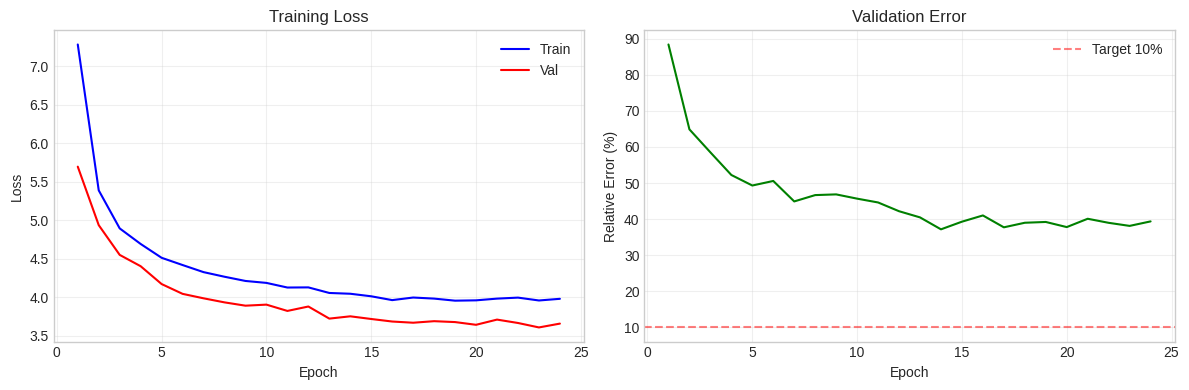

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# Визуализация
# ═══════════════════════════════════════════════════════════════════════════════

if trainer and len(trainer.train_losses) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    epochs_range = range(1, len(trainer.train_losses) + 1)
    
    # Loss
    axes[0].plot(epochs_range, trainer.train_losses, 'b-', label='Train')
    axes[0].plot(epochs_range, trainer.val_losses, 'r-', label='Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error
    axes[1].plot(epochs_range, trainer.val_errors, 'g-')
    axes[1].axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Target 10%')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Relative Error (%)')
    axes[1].set_title('Validation Error')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    Path(cfg.checkpoint_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(Path(cfg.checkpoint_dir) / "training_curves.png", dpi=150)
    plt.show()

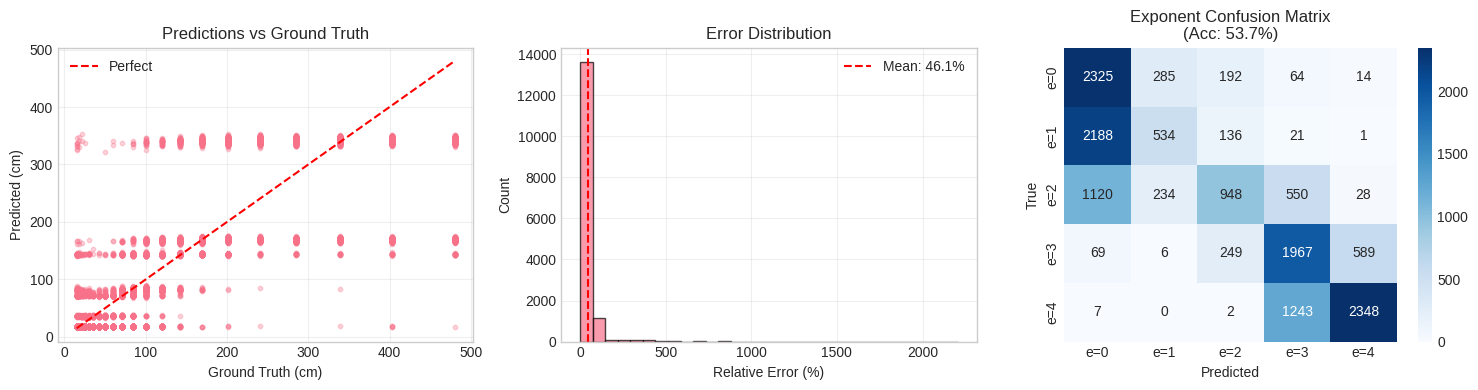

In [ ]:
if metrics:
    preds = np.array(metrics['predictions'])
    gts = np.array(metrics['ground_truths'])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Predictions vs GT
    axes[0].scatter(gts, preds, alpha=0.3, s=10)
    lims = [min(gts.min(), preds.min()), max(gts.max(), preds.max())]
    axes[0].plot(lims, lims, 'r--', label='Perfect')
    axes[0].set_xlabel('Ground Truth (cm)')
    axes[0].set_ylabel('Predicted (cm)')
    axes[0].set_title('Predictions vs Ground Truth')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution (GSD >= 15 см, деление безопасно)
    errors = np.abs(preds - gts) / gts * 100
    axes[1].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[1].axvline(np.mean(errors), color='r', linestyle='--', label=f'Mean: {np.mean(errors):.1f}%')
    axes[1].set_xlabel('Relative Error (%)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Error Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = np.array(metrics['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=[f'e={i}' for i in range(5)],
                yticklabels=[f'e={i}' for i in range(5)])
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')
    axes[2].set_title(f'Exponent Confusion Matrix\n(Acc: {metrics["exponent_accuracy"]:.1f}%)')
    
    plt.tight_layout()
    plt.savefig(Path(cfg.checkpoint_dir) / "evaluation_results.png", dpi=150)
    plt.show()

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# Сохранение модели и метрик
# ═══════════════════════════════════════════════════════════════════════════════

if trainer:
    checkpoint_dir = Path(cfg.checkpoint_dir)
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    # Сохраняем полный checkpoint (модель + optimizer + scheduler + история)
    model_path = checkpoint_dir / f"gsd_model_{cfg.backbone}.pth"
    checkpoint = trainer.get_checkpoint()
    torch.save(checkpoint, model_path)
    print(f"Checkpoint saved: {model_path} ({model_path.stat().st_size / 1024**2:.1f} MB)")
    print(f"  - Best epoch: {checkpoint['epoch']+1}, Best error: {checkpoint['best_val_error']:.2f}%")
    
    # Сохраняем метрики отдельно в JSON для удобства
    if metrics:
        metrics_to_save = {k: v for k, v in metrics.items() if not isinstance(v, list)}
        with open(checkpoint_dir / "gsd_metrics.json", 'w') as f:
            json.dump(metrics_to_save, f, indent=2)
        print(f"Metrics saved: {checkpoint_dir / 'gsd_metrics.json'}")

Checkpoint saved: /home/user/code/dls_project/checkpoints/gsd_model_resnet101.pth (163.2 MB)
  - Best epoch: 14, Best error: 37.18%
Metrics saved: /home/user/code/dls_project/checkpoints/gsd_metrics.json


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# Inference: предсказание GSD для нового изображения
# ═══════════════════════════════════════════════════════════════════════════════

GSD_CLASS_INFO = {
    # Границы классов: [15×2^e, 30×2^e) для e ∈ {0,1,2,3}, [240, 480] для e=4
    0: {'range': '[15, 30) cm', 'quality': 'Very High', 'sources': 'Drones, WorldView, GeoEye'},
    1: {'range': '[30, 60) cm', 'quality': 'High', 'sources': 'SkySat, Pleiades, SPOT-6/7'},
    2: {'range': '[60, 120) cm', 'quality': 'Medium', 'sources': 'Commercial satellites (resampled)'},
    3: {'range': '[120, 240) cm', 'quality': 'Low', 'sources': 'RapidEye, SPOT-5'},
    4: {'range': '[240, 480] cm', 'quality': 'Very Low', 'sources': 'Aerial/satellite (downsampled)'}
}


def predict_gsd(
    image_path: str, 
    model: nn.Module, 
    device: torch.device,
    patch_size: int = 256,
    num_patches: int = 5,
    seed: int = 42
) -> Dict:
    """
    Predict GSD for a single image using multiple patches (consistent with training).
    
    Extracts num_patches random patches and averages predictions for robustness.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    
    with Image.open(image_path) as img:
        img_array = np.array(img.convert('RGB'))
    h, w = img_array.shape[:2]
    
    # Если изображение меньше patch_size - ресайзим всё изображение
    if h < patch_size or w < patch_size:
        img_array = cv2.resize(img_array, (patch_size, patch_size), interpolation=cv2.INTER_LINEAR)
        h, w = patch_size, patch_size
        warnings.warn(f"Image smaller than patch_size ({patch_size}), resized to fit")
    
    # Извлекаем патчи (центральный + случайные)
    rng = random.Random(seed)
    patches = []
    
    # Центральный патч
    cy, cx = (h - patch_size) // 2, (w - patch_size) // 2
    patches.append(img_array[cy:cy+patch_size, cx:cx+patch_size])
    
    # Случайные патчи
    for _ in range(num_patches - 1):
        y = rng.randint(0, h - patch_size) if h > patch_size else 0
        x = rng.randint(0, w - patch_size) if w > patch_size else 0
        patches.append(img_array[y:y+patch_size, x:x+patch_size])
    
    # Преобразуем в batch тензор
    batch = torch.stack([transform(Image.fromarray(p)) for p in patches]).to(device)
    
    model.eval()
    with torch.inference_mode():
        model_out = model(batch)
    
    # Усредняем предсказания
    gsd_mean = model_out['gsd'].mean().item()
    gsd_std = model_out['gsd'].std().item()
    
    # Мажоритарное голосование для экспоненты
    exponents = model_out['selected_class'].cpu().tolist()
    exponent = Counter(exponents).most_common(1)[0][0]
    
    # Средняя confidence для выбранного класса
    probs = torch.softmax(model_out['class_logits'], dim=1)
    confidence = probs[:, exponent].mean().item()
    
    return {
        'gsd_cm': gsd_mean,
        'gsd_std_cm': gsd_std,
        'gsd_m': gsd_mean / 100.0,
        'exponent': exponent,
        'mantissa': model_out['mantissa'].mean().item(),
        'confidence': confidence,
        'class_info': GSD_CLASS_INFO[exponent],
        'num_patches': num_patches
    }

In [ ]:
# Пример inference
if dataset_exists and trainer and train_images:
    sample_path = train_images[np.random.default_rng(SEED).integers(len(train_images))]
    result = predict_gsd(str(sample_path), model, DEVICE, patch_size=cfg.patch_size, seed=SEED)
    
    print(f"Image: {sample_path.name}")
    print(f"Predicted GSD: {result['gsd_cm']:.1f} ± {result['gsd_std_cm']:.1f} cm ({result['gsd_m']:.2f} m)")
    print(f"Exponent: {result['exponent']} (mantissa: {result['mantissa']:.3f})")
    print(f"Confidence: {result['confidence']*100:.1f}% (from {result['num_patches']} patches)")
    print(f"Quality: {result['class_info']['quality']} ({result['class_info']['range']})")
    print(f"Typical sources: {result['class_info']['sources']}")

Image: austin24.tif
Predicted GSD: 25.1 ± 9.7 cm (0.25 m)
Exponent: 0 (mantissa: 0.896)
Confidence: 54.0% (from 5 patches)
Quality: Very High ([15, 30) cm)
Typical sources: Drones, WorldView, GeoEye


# Evaluation

Тестирование обученной модели на 10 изображениях из test set с multi-scale GSD симуляцией.

**Тестовые GSD:** 15, 30, 60, 120, 240 см (по одному на каждый класс экспоненты e=0..4)

In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# Загрузка 10 тестовых изображений
# ═══════════════════════════════════════════════════════════════════════════════

test_images_dir = Path(cfg.inria_path) / "test" / "images"
all_test_images = sorted(test_images_dir.glob("*.tif"))

# Берём первые 10 изображений (отсортированных по имени)
NUM_TEST_IMAGES = 10
selected_test_images = all_test_images[:NUM_TEST_IMAGES]

print(f"Available test images: {len(all_test_images)}")
print(f"Selected for testing: {len(selected_test_images)}")
print("\nSelected images:")
for i, img_path in enumerate(selected_test_images):
    print(f"  {i+1}. {img_path.name}")

Available test images: 180
Selected for testing: 10

Selected images:
  1. bellingham1.tif
  2. bellingham10.tif
  3. bellingham11.tif
  4. bellingham12.tif
  5. bellingham13.tif
  6. bellingham14.tif
  7. bellingham15.tif
  8. bellingham16.tif
  9. bellingham17.tif
  10. bellingham18.tif


In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# Загрузка модели и весов из checkpoint
# ═══════════════════════════════════════════════════════════════════════════════

# Путь к checkpoint
checkpoint_path = Path(cfg.checkpoint_dir) / "gsd_model_resnet101.pth"

# Создаём модель с той же архитектурой
test_model = RegressionTreeCNN(
    backbone=cfg.backbone,
    num_exponent_classes=cfg.num_exponent_classes,
    gsd_min=15.0,
    gsd_max=480.0
)

# Загружаем checkpoint
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
test_model.load_state_dict(checkpoint['model'])
test_model = test_model.to(DEVICE)
test_model.eval()

print(f"Checkpoint loaded: {checkpoint_path.name}")
print(f"  - Best epoch: {checkpoint['epoch'] + 1}")
print(f"  - Best val error: {checkpoint['best_val_error']:.2f}%")
print(f"  - Device: {DEVICE}")

Loaded resnet101 with pretrained ImageNet weights via timm
Checkpoint loaded: gsd_model_resnet101.pth
  - Best epoch: 14
  - Best val error: 37.18%
  - Device: cuda:0


In [18]:
# ═══════════════════════════════════════════════════════════════════════════════
# Генерация тестовых патчей с multi-scale GSD
# ═══════════════════════════════════════════════════════════════════════════════

# Тестовые значения GSD — по одному на каждый класс экспоненты (0-4)
TEST_GSDS = [15, 30, 60, 120, 240]  # см
PATCHES_PER_COMBINATION = 4
PATCH_SIZE = 256
ORIGINAL_GSD = 30.0  # INRIA dataset: 30 см/пиксель

# Трансформация для inference (без аугментаций)
inference_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

def extract_multiscale_patch(
    img_array: np.ndarray,
    target_gsd: float,
    original_gsd: float,
    patch_size: int,
    rng: random.Random
) -> np.ndarray:
    """Extract a patch simulating target GSD via resampling."""
    h, w = img_array.shape[:2]
    
    if target_gsd < original_gsd:
        # Увеличиваем разрешение: берём меньший участок и растягиваем
        source_size = int(patch_size * target_gsd / original_gsd)
        source_size = max(32, min(source_size, min(h, w)))
        y = rng.randint(0, max(0, h - source_size))
        x = rng.randint(0, max(0, w - source_size))
        patch = img_array[y:y+source_size, x:x+source_size]
        patch = cv2.resize(patch, (patch_size, patch_size), interpolation=cv2.INTER_LINEAR)
    elif target_gsd > original_gsd:
        # Уменьшаем разрешение: берём патч и сжимаем-растягиваем
        source_size = int(patch_size * original_gsd / target_gsd)
        source_size = max(32, source_size)
        y = rng.randint(0, max(0, h - patch_size))
        x = rng.randint(0, max(0, w - patch_size))
        patch = img_array[y:y+patch_size, x:x+patch_size]
        patch = cv2.resize(patch, (source_size, source_size), interpolation=cv2.INTER_AREA)
        patch = cv2.resize(patch, (patch_size, patch_size), interpolation=cv2.INTER_LINEAR)
    else:
        # GSD совпадает — просто берём случайный патч
        y = rng.randint(0, max(0, h - patch_size))
        x = rng.randint(0, max(0, w - patch_size))
        patch = img_array[y:y+patch_size, x:x+patch_size]
    
    return patch

# Генерация тестовых данных
seed_everything(42)
rng = random.Random(42)

test_data = []
print("Generating test patches...")

for img_path in tqdm(selected_test_images, desc="Images"):
    with Image.open(img_path) as img:
        img_array = np.array(img.convert('RGB'))
    
    for target_gsd in TEST_GSDS:
        true_exp = gsd_to_exponent(target_gsd)
        true_mant = gsd_to_mantissa(target_gsd, true_exp)
        
        for patch_idx in range(PATCHES_PER_COMBINATION):
            patch = extract_multiscale_patch(
                img_array, target_gsd, ORIGINAL_GSD, PATCH_SIZE, rng
            )
            patch_tensor = inference_transform(Image.fromarray(patch))
            
            test_data.append({
                'image_name': img_path.stem,
                'target_gsd': target_gsd,
                'true_exponent': true_exp,
                'true_mantissa': true_mant,
                'patch': patch_tensor
            })

print(f"\nTotal test samples: {len(test_data)}")
print(f"  - {NUM_TEST_IMAGES} images × {len(TEST_GSDS)} GSDs × {PATCHES_PER_COMBINATION} patches")

Generating test patches...


Images: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


Total test samples: 200
  - 10 images × 5 GSDs × 4 patches


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# Inference и вычисление метрик
# ═══════════════════════════════════════════════════════════════════════════════

# Собираем патчи в батчи для inference
all_patches = torch.stack([d['patch'] for d in test_data]).to(DEVICE)

# Inference
print("Running inference...")
with torch.inference_mode():
    output = test_model(all_patches)
    pred_exponents = output['selected_class'].cpu().numpy()
    pred_mantissas = output['mantissa'].cpu().numpy()

# Реконструкция предсказанных GSD: GSD = 20 × mantissa × 2^exponent
pred_gsds = 20.0 * pred_mantissas * (2.0 ** pred_exponents)

# Добавляем предсказания в данные
for i, d in enumerate(test_data):
    d['pred_exponent'] = pred_exponents[i]
    d['pred_mantissa'] = pred_mantissas[i]
    d['pred_gsd'] = pred_gsds[i]

# Агрегация: усреднение по 4 патчам для каждой пары (image, GSD)
aggregated_results = []
for img_path in selected_test_images:
    img_name = img_path.stem
    for target_gsd in TEST_GSDS:
        patches_for_combo = [
            d for d in test_data 
            if d['image_name'] == img_name and d['target_gsd'] == target_gsd
        ]
        avg_pred_gsd = np.mean([d['pred_gsd'] for d in patches_for_combo])
        true_exp = patches_for_combo[0]['true_exponent']
        
        aggregated_results.append({
            'image': img_name,
            'real_gsd': target_gsd,
            'pred_gsd': avg_pred_gsd,
            'exponent_class': true_exp,
            'error_cm': abs(avg_pred_gsd - target_gsd),
            'error_pct': abs(avg_pred_gsd - target_gsd) / target_gsd * 100
        })

# Вычисление метрик
real_gsds = np.array([r['real_gsd'] for r in aggregated_results])
pred_gsds_agg = np.array([r['pred_gsd'] for r in aggregated_results])
errors = pred_gsds_agg - real_gsds

mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors ** 2))
mean_rel_error = np.mean(np.abs(errors) / real_gsds) * 100
correlation = np.corrcoef(real_gsds, pred_gsds_agg)[0, 1]

print(f"\n{'='*50}")
print("Test Metrics (aggregated over {len(aggregated_results)} samples):")
print(f"{'='*50}")
print(f"  MAE:                {mae:.2f} cm")
print(f"  RMSE:               {rmse:.2f} cm")
print(f"  Mean Relative Error: {mean_rel_error:.2f}%")
print(f"  Pearson Correlation: {correlation:.4f}")

Running inference...

Test Metrics (aggregated over {len(aggregated_results)} samples):
  MAE:                21.54 cm
  RMSE:               30.13 cm
  Mean Relative Error: 31.25%
  Pearson Correlation: 0.9738


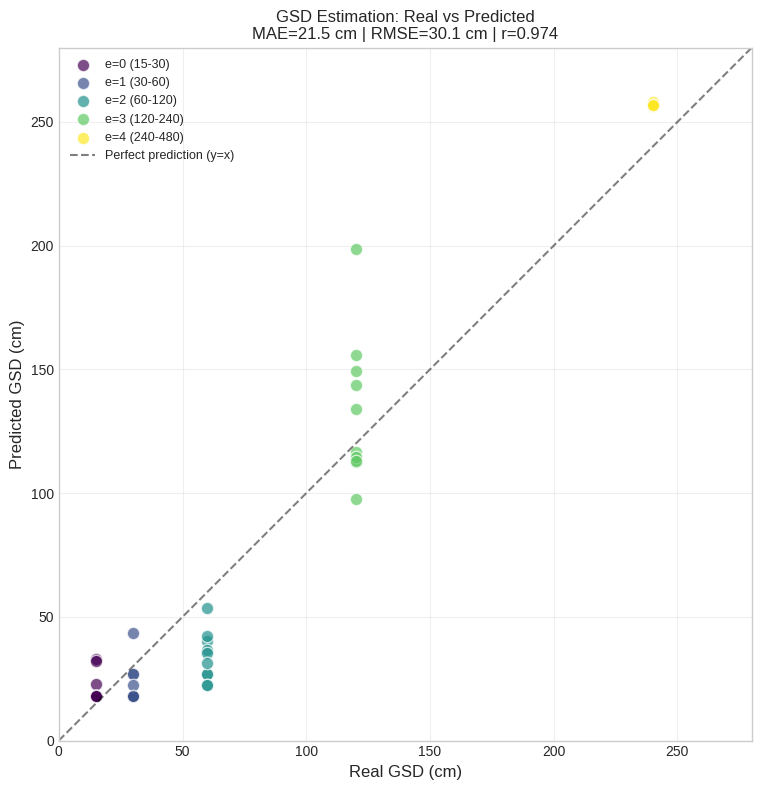

In [21]:
# ═══════════════════════════════════════════════════════════════════════════════
# Визуализация: Real GSD vs Predicted GSD
# ═══════════════════════════════════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(8, 8))

# Цвета для классов экспоненты
colors = plt.cm.viridis(np.linspace(0, 1, 5))
class_labels = ['e=0 (15-30)', 'e=1 (30-60)', 'e=2 (60-120)', 'e=3 (120-240)', 'e=4 (240-480)']

# Scatter plot по классам
for exp_class in range(5):
    mask = [r['exponent_class'] == exp_class for r in aggregated_results]
    x = [r['real_gsd'] for r, m in zip(aggregated_results, mask) if m]
    y = [r['pred_gsd'] for r, m in zip(aggregated_results, mask) if m]
    ax.scatter(x, y, c=[colors[exp_class]], label=class_labels[exp_class], s=80, alpha=0.7, edgecolors='white')

# Линия идеального предсказания y=x
ax.plot([0, 500], [0, 500], 'k--', alpha=0.5, label='Perfect prediction (y=x)')

# Оформление
ax.set_xlabel('Real GSD (cm)', fontsize=12)
ax.set_ylabel('Predicted GSD (cm)', fontsize=12)
ax.set_title(
    f'GSD Estimation: Real vs Predicted\n'
    f'MAE={mae:.1f} cm | RMSE={rmse:.1f} cm | r={correlation:.3f}',
    fontsize=12
)
ax.legend(loc='upper left', fontsize=9)
ax.set_xlim(0, 280)
ax.set_ylim(0, 280)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# Таблица результатов
# ═══════════════════════════════════════════════════════════════════════════════

import pandas as pd

# Создаём DataFrame
results_df = pd.DataFrame(aggregated_results)
results_df = results_df[['image', 'real_gsd', 'pred_gsd', 'error_cm', 'error_pct']]
results_df.columns = ['Image', 'Real_GSD', 'Predicted_GSD', 'Error_cm', 'Error_%']
results_df['Predicted_GSD'] = results_df['Predicted_GSD'].round(1)
results_df['Error_cm'] = results_df['Error_cm'].round(1)
results_df['Error_%'] = results_df['Error_%'].round(1)

print("Results Table (first 10 rows):")
print("=" * 70)
display(results_df.head(10))

# Сводка по классам GSD
print("\n\nSummary by GSD class:")
print("=" * 70)
summary = results_df.groupby('Real_GSD').agg({
    'Error_cm': ['mean', 'std'],
    'Error_%': ['mean', 'std']
}).round(2)
summary.columns = ['MAE (cm)', 'Std (cm)', 'MAPE (%)', 'Std (%)']
display(summary)

Results Table (first 10 rows):


,Image,Real_GSD,Predicted_GSD,Error_cm,Error_%
0,bellingham1,15,17.9,2.9,19.6
1,bellingham1,30,18.0,12.0,40.2
2,bellingham1,60,26.9,33.1,55.1
3,bellingham1,120,155.9,35.9,29.9
4,bellingham1,240,256.7,16.7,7.0
5,bellingham10,15,18.0,3.0,20.2
6,bellingham10,30,18.0,12.0,40.1
7,bellingham10,60,40.2,19.8,33.1
8,bellingham10,120,198.5,78.5,65.5
9,bellingham10,240,300.3,60.3,25.1




Summary by GSD class:


,MAE (cm),Std (cm),MAPE (%),Std (%)
Real_GSD,,,,
15,6.43,6.13,42.80,40.76
30,9.96,3.95,33.28,13.18
60,26.12,9.83,43.54,16.36
120,22.76,22.49,18.97,18.77
240,42.43,29.94,17.68,12.47


## Заключение

Реализован pipeline обучения **Regression Tree CNN** по статье Lee & Sull (2019) — **полная реализация**.

### Результаты обучения
- **Best epoch:** 14 из 32 (early stopping)
- **Best validation error:** 37.18%

### Результаты тестирования (10 изображений × 5 GSD × 4 патча = 200 samples)
| Метрика | Значение |
|---------|----------|
| MAE | 21.54 cm |
| RMSE | 30.13 cm |
| Mean Relative Error | 31.25% |
| Pearson Correlation | 0.9738 |

### Архитектура (точно по статье)
- **Backbone:** ResNet-101 (frozen, pretrained ImageNet) — 2048-D spatial features 8×8
- **Binomial Tree Layer:** полная иерархическая структура
  - Level 0: 1 узел (root) с feature map
  - Level l: (l+1) узлов с локальной классификацией
  - Границы уровня l: 15 × (480/15)^(i/l), i = 0..l
  - Выбор узла по L2 норме (Equation 11)
  - Leaf nodes (level C-1): C=5 классов, V=16 vector dim
  - **Mantissa head:** два pointwise conv (V→64→1) на feature map до GAP
- **Floating-point представление:** GSD = 20 × mantissa × 2^exponent

### Loss Function (точно по статье)
```
L = Σ_{l=1}^{depth-1} Le(level_l) + λ × Lm
```
- **Le:** CrossEntropy на каждом уровне (локальная классификация)
- **Lm:** L1 loss для mantissa
- **Backprop:** Le → все узлы получают градиенты; Lm → только выбранный путь

### Dataset (точно по статье)
- **Log GSD scale:** GSD = 15 × 2^x, x uniform в [0, 5]
- 21 значение от 15 до 480 см по логарифмической шкале

### Параметры обучения (точно по статье)
- **Epochs:** 32 (max), **Batch size:** 32
- **Optimizer:** Adam (lr=1e-4, weight_decay=1e-4)
- **LR decay:** ×0.1 на 16-й и 24-й эпохах
- **λ = 10.0**, **He initialization**

### Data Augmentation (точно по статье)
- **10% simulated classification errors** (±1 класс)
- **Adjusted mantissa** для robustness

### Классы экспоненты
| e | Диапазон GSD | Разрешение |
|---|--------------|------------|
| 0 | [15, 30) см | Очень высокое |
| 1 | [30, 60) см | Высокое |
| 2 | [60, 120) см | Среднее |
| 3 | [120, 240) см | Низкое |
| 4 | [240, 480] см | Очень низкое |

**Ссылки:**
- [Lee & Sull (2019)](https://doi.org/10.3390/rs11192276)
- [INRIA Dataset](https://project.inria.fr/aerialimagelabeling/)